In [1]:
%load_ext autoreload
%autoreload 2

from pyfishsensedev.image import ImageRectifier, RawProcessor
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from pyfishsensedev.calibration import LensCalibration, LaserCalibration
from pyfishsensedev.image.image_processors.raw_processor_old import RawProcessorOld
from pyfishsensedev.laser.nn_laser_detector import NNLaserDetector
from pyfishsensedev.depth_map import LaserDepthMap, DepthAnythingDepthMap
import torch
from pyfishsensedev.image import ImageRectifier, RawProcessor, ColorCorrection
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [2]:
ORF_FILE = Path("../../fishsense-lite/demo/data/P7170081.ORF")
LENS_CALIBRATION_FILE = Path("./data/lens-calibration.pkg")
LASER_CALIBRATION_FILE = Path("./data/laser-calibration.pkg")

In [3]:
lens_calibration = LensCalibration()
lens_calibration.load(LENS_CALIBRATION_FILE)

laser_calibration = LaserCalibration()
laser_calibration.load(LASER_CALIBRATION_FILE)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def uint8_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 255

def uint16_2_double(img: np.ndarray) -> np.ndarray:
    return img.astype(np.float64) / 65535

def double_2_uint8(img: np.ndarray) -> np.ndarray:
    return (img * 255).astype(np.uint8)

def uint16_2_uint8(img: np.ndarray) -> np.ndarray:
    return double_2_uint8(uint16_2_double(img))

def imshow(img: np.ndarray | Image.Image):
    if hasattr(img, "dtype"):
        arr = img
    elif isinstance(img, Image.Image):
        arr = np.array(img)

    if arr.dtype == np.uint16:
        arr = uint16_2_uint8(img)
    elif arr.dtype == float:
        arr = double_2_uint8(arr / arr.max())

    plt.imshow(cv2.cvtColor(arr, cv2.COLOR_BGR2RGB))

In [6]:
raw_process = RawProcessor(ORF_FILE)
dark_raw_processor = RawProcessorOld(Path(ORF_FILE), enable_histogram_equalization=False)

image_rectifier = ImageRectifier(lens_calibration)

img = next(raw_process.__iter__())
img = image_rectifier.rectify(img)

img_dark = next(dark_raw_processor.__iter__())
img_dark = image_rectifier.rectify(img_dark)

img8 = uint16_2_uint8(img)
img_dark8 = uint16_2_uint8(img_dark)

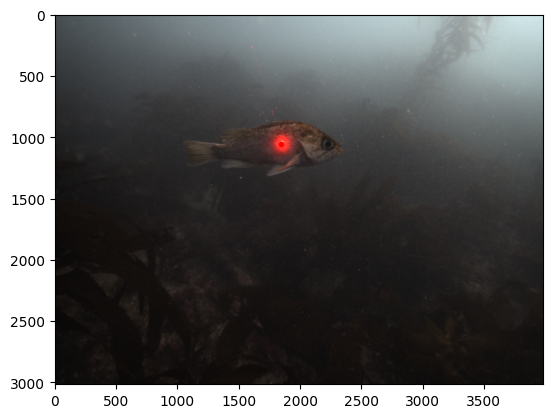

In [7]:
laser_detector = NNLaserDetector(lens_calibration, laser_calibration, device)
laser_coords = laser_detector.find_laser(img_dark8)
laser_coords_int = np.round(laser_coords).astype(int)

imshow(img_dark8)
plt.plot(laser_coords[0], laser_coords[1], 'r.')
plt.show()

In [8]:
depth_map = LaserDepthMap(laser_coords, lens_calibration, laser_calibration)

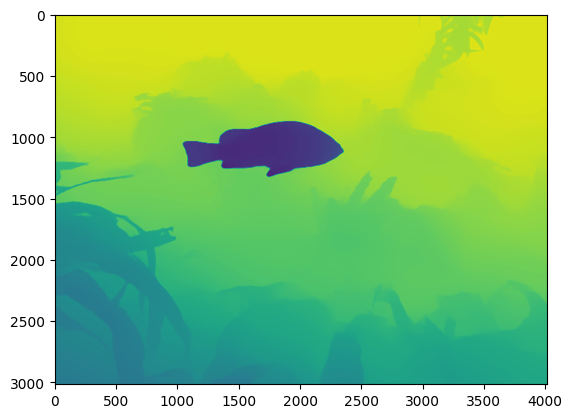

In [9]:
ml_depth_map = DepthAnythingDepthMap(img8, device)
scale = depth_map.depth_map[0, 0] / ml_depth_map.depth_map[int(laser_coords[1]), int(laser_coords[0])]
ml_depth_map.rescale(scale)

plt.imshow(ml_depth_map.depth_map)

In [ ]:
color_correction = ColorCorrection()
img_corrected = color_correction.correct_color(img8, ml_depth_map)

imshow(img_corrected)

Estimating backscatter...


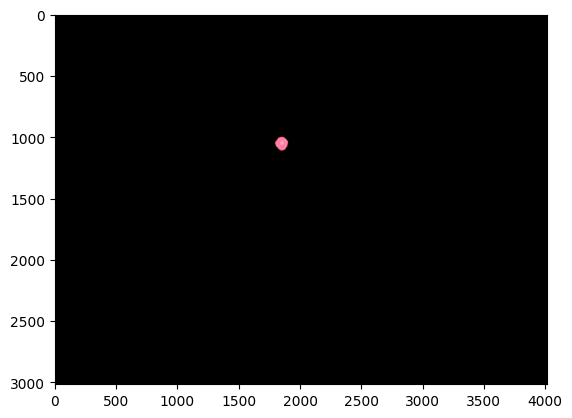

In [ ]:
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-small")

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(img_corrected)
    masks, _, _ = predictor.predict(point_coords=[laser_coords], point_labels=[1])
    prev_mask = masks[0]

    add_value = 1
    while True:
        point_coords = {tuple(laser_coords)}

        point_coords.add((laser_coords[0] - add_value, laser_coords[1] - 0))
        point_coords.add((laser_coords[0] - add_value, laser_coords[1] - add_value))
        point_coords.add((laser_coords[0] - 0, laser_coords[1] - add_value))
                            
        point_coords.add((laser_coords[0] + add_value, laser_coords[1] + 0))
        point_coords.add((laser_coords[0] + add_value, laser_coords[1] + add_value))
        point_coords.add((laser_coords[0] + 0, laser_coords[1] + add_value))

        masks, _, _ = predictor.predict(point_coords=np.array(list(point_coords)), point_labels=[1 for _ in point_coords])

        if prev_mask.sum() == masks[0].sum():
            break

        prev_mask = masks[0]
        add_value += 1

img_cpy = img_corrected.copy()
img_cpy[np.logical_not(masks[0].astype(bool)), :] = 0
imshow(img_cpy)